In [189]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [190]:
day_0 = pd.read_csv("prices_round_2_day_-1.csv", sep=";") # day -1
day_1 = pd.read_csv("prices_round_2_day_0.csv", sep=";")
day_2 = pd.read_csv("prices_round_2_day_1.csv", sep=";")

all_days = pd.concat([day_0,day_1,day_2], ignore_index=True)
print(all_days.info)
print(all_days.head())
print(7 * 360)

<bound method DataFrame.info of        timestamp  ORCHIDS  TRANSPORT_FEES  EXPORT_TARIFF  IMPORT_TARIFF  \
0              0  1200.00             1.5           10.5           -2.0   
1            100  1201.75             1.5            9.5           -2.0   
2            200  1201.75             1.5            9.5           -2.0   
3            300  1201.75             1.5            9.5           -2.0   
4            400  1201.75             1.5            9.5           -2.0   
...          ...      ...             ...            ...            ...   
29998     999600  1036.25             0.9            9.5           -5.0   
29999     999700  1036.25             0.9            9.5           -5.0   
30000     999800  1036.25             0.9            9.5           -5.0   
30001     999900  1034.25             0.9            9.5           -5.0   
30002    1000000  1035.25             0.9            9.5           -5.0   

        SUNLIGHT  HUMIDITY  DAY  
0      2500.0000  79.00000   -1  

In [191]:
OPTIMAL_SUNLIGHT = 7 * 360
# any dip below 7 hours with 4% production dip for 10 minutes
SUNLIGHT_RATE_OF_CHANGE = .04/10

OPTIMAL_HUMIDITY = [60,80]
# 2% production for 5% humidity change outside optimal range
HUMIDTY_RATE_OF_CHANGE = .02/.04 # note humidity is already in %

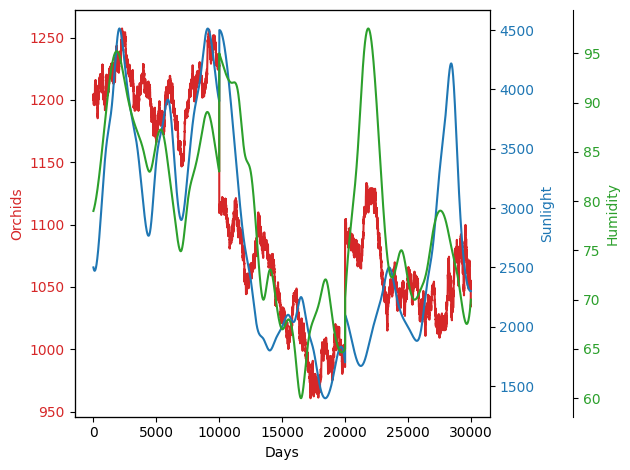

In [192]:
fig, ax1 = plt.subplots()

# Plot "ORCHIDS" on the first y-axis.
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Orchids', color=color)
ax1.plot(all_days.index, all_days['ORCHIDS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for "SUNLIGHT".
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sunlight', color=color)
ax2.plot(all_days.index, all_days['SUNLIGHT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis for "HUMIDITY".
ax3 = ax1.twinx()
color = 'tab:green'
# Offset the right spine of ax3. The ticks and label have already been set above.
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right.
ax3.set_ylabel('Humidity', color=color)
ax3.plot(all_days.index, all_days['HUMIDITY'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [193]:
# calculate the rolling window of 30 days for sunlight 
sunlight = all_days.get(['timestamp','SUNLIGHT']).fillna(0)
sunlight['SMA_30'] = sunlight['SUNLIGHT'].rolling(30).mean().fillna(0) # simple moving average
sunlight['Pct_Change'] = sunlight['SUNLIGHT'].pct_change().fillna(0) * 100 # multiply by 100
sunlight['EMA_30'] = sunlight['SUNLIGHT'].ewm(span=30, adjust=False).mean().fillna(0)
sunlight['STD_30'] = sunlight['SUNLIGHT'].rolling(30).std().fillna(0)
sunlight['Pct_Change_Stdev'] = sunlight['Pct_Change'].rolling(30).std().fillna(0)
print(sunlight.head())

   timestamp   SUNLIGHT  SMA_30  Pct_Change       EMA_30  STD_30  \
0          0  2500.0000     0.0    0.000000  2500.000000     0.0   
1        100  2499.4197     0.0   -0.023212  2499.962561     0.0   
2        200  2498.8457     0.0   -0.022965  2499.890506     0.0   
3        300  2498.2780     0.0   -0.022718  2499.786473     0.0   
4        400  2497.7166     0.0   -0.022471  2499.652933     0.0   

   Pct_Change_Stdev  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


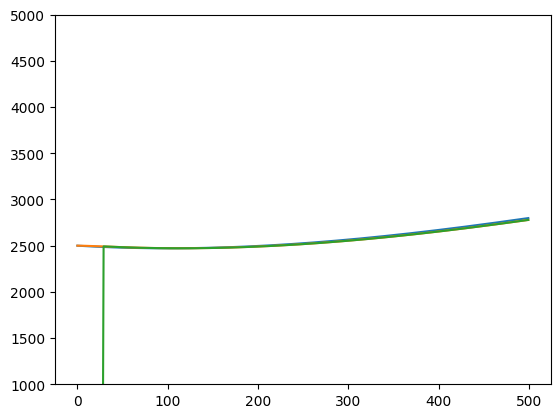

In [194]:
# plot the SMA, EMA, and SUNLIGHT
plt.plot(sunlight['SUNLIGHT'][:500])
plt.plot(sunlight['EMA_30'][:500])
plt.plot(sunlight['SMA_30'][:500])
plt.ylim(1000,5000)
plt.show()

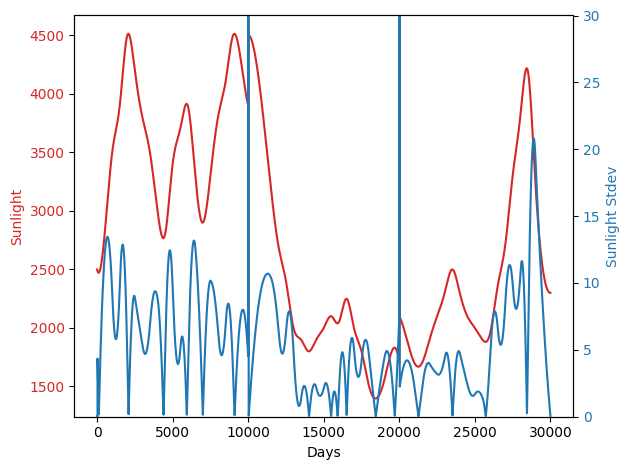

In [195]:
fig, ax1 = plt.subplots()

# Plot "ORCHIDS" on the first y-axis.
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Sunlight', color=color)
ax1.plot(sunlight.index, sunlight['SUNLIGHT'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for "SUNLIGHT".
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sunlight Stdev', color=color)
ax2.plot(sunlight.index, sunlight['STD_30'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,30])

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

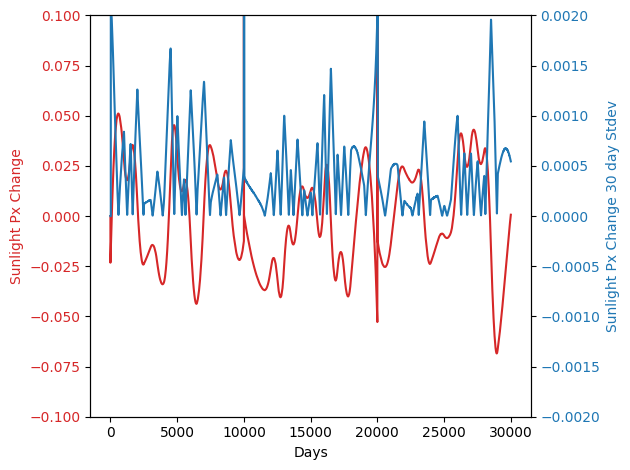

In [196]:
fig, ax1 = plt.subplots()

# Plot "ORCHIDS" on the first y-axis.
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Sunlight Px Change', color=color)
ax1.plot(sunlight.index, sunlight['Pct_Change'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-.1,.1])

# Create a second y-axis for "SUNLIGHT".
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sunlight Px Change 30 day Stdev', color=color)
ax2.plot(sunlight.index, sunlight['Pct_Change_Stdev'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-.002,.002])

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [197]:
# plot periods where the standard deviation exceeds 10
#sunlight['STD_threshold'] = sunlight['STD_30'] > 3
sunlight['STD_threshold'] = sunlight['STD_30'].rolling(30).mean().fillna(0)*2
print(sunlight['STD_threshold'][:500])

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
495    23.440526
496    23.474238
497    23.507783
498    23.541163
499    23.574377
Name: STD_threshold, Length: 500, dtype: float64


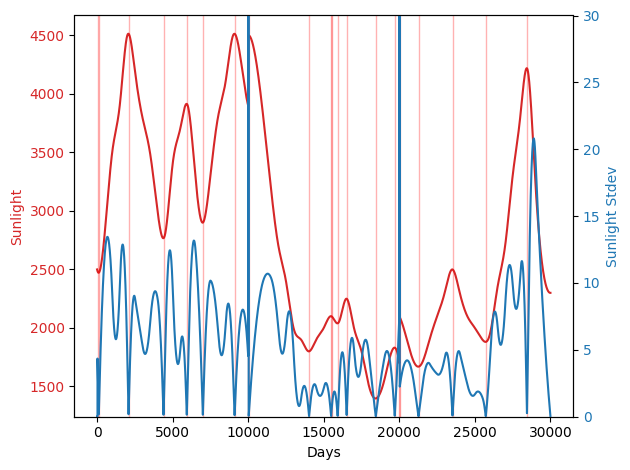

In [198]:
fig, ax1 = plt.subplots()

# Plot "ORCHIDS" on the first y-axis.
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Sunlight', color=color)
ax1.plot(sunlight.index, sunlight['SUNLIGHT'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for "SUNLIGHT".
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sunlight Stdev', color=color)
ax2.plot(sunlight.index, sunlight['STD_30'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,30])


start_holding = None
end_holding = None
std_above_threshold = sunlight['STD_30'] > sunlight['STD_threshold']
for idx in sunlight.index:
    if std_above_threshold[idx] == True:
        if not start_holding:
            start_holding = idx
    else:
        if start_holding:
            end_holding = idx
            # Plot the holding period in red overlay
            plt.axvspan(start_holding, end_holding, color='red', alpha=0.3)

            start_holding = None
            end_holding = None

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()


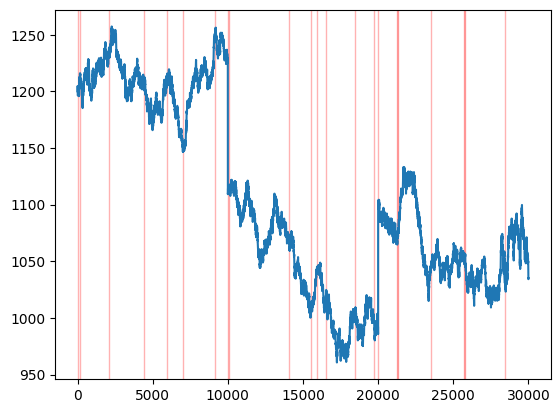

14000    0.385306
14001    0.372164
14002    0.358987
14003    0.345778
14004    0.332535
           ...   
14995    2.111314
14996    2.116011
14997    2.120722
14998    2.125447
14999    2.130201
Name: STD_30, Length: 1000, dtype: float64

In [199]:
plt.plot(all_days['ORCHIDS'])
start_holding = None
end_holding = None
std_above_threshold = sunlight['STD_30'] > sunlight['STD_threshold']
for idx in sunlight.index:
    if std_above_threshold[idx] == True:
        if not start_holding:
            start_holding = idx
    else:
        if start_holding:
            end_holding = idx
            # Plot the holding period in red overlay
            plt.axvspan(start_holding, end_holding, color='red', alpha=0.3)

            start_holding = None
            end_holding = None
plt.show()
sunlight['STD_30'][14000:15000]

In [200]:
# Check z-score as a metric
# For Z-score, you will need the mean and standard deviation, we will use EMA and STD_30
print(sunlight.head())

   timestamp   SUNLIGHT  SMA_30  Pct_Change       EMA_30  STD_30  \
0          0  2500.0000     0.0    0.000000  2500.000000     0.0   
1        100  2499.4197     0.0   -0.023212  2499.962561     0.0   
2        200  2498.8457     0.0   -0.022965  2499.890506     0.0   
3        300  2498.2780     0.0   -0.022718  2499.786473     0.0   
4        400  2497.7166     0.0   -0.022471  2499.652933     0.0   

   Pct_Change_Stdev  STD_threshold  
0               0.0            0.0  
1               0.0            0.0  
2               0.0            0.0  
3               0.0            0.0  
4               0.0            0.0  


In [201]:
sunlight['Sunlight_Z'] = (sunlight['SUNLIGHT'] - sunlight['EMA_30']) / sunlight['STD_30']
sunlight['Sunlight_Z'] = sunlight['Sunlight_Z'].fillna(0).replace([np.inf, -np.inf], 0)
print(sunlight['Sunlight_Z'].head(300))
print(sunlight.head())

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
295    1.641395
296    1.641444
297    1.641501
298    1.641543
299    1.641570
Name: Sunlight_Z, Length: 300, dtype: float64
   timestamp   SUNLIGHT  SMA_30  Pct_Change       EMA_30  STD_30  \
0          0  2500.0000     0.0    0.000000  2500.000000     0.0   
1        100  2499.4197     0.0   -0.023212  2499.962561     0.0   
2        200  2498.8457     0.0   -0.022965  2499.890506     0.0   
3        300  2498.2780     0.0   -0.022718  2499.786473     0.0   
4        400  2497.7166     0.0   -0.022471  2499.652933     0.0   

   Pct_Change_Stdev  STD_threshold  Sunlight_Z  
0               0.0            0.0         0.0  
1               0.0            0.0         0.0  
2               0.0            0.0         0.0  
3               0.0            0.0         0.0  
4               0.0            0.0         0.0  


In [202]:
# Identify large Z-scores
massive_fluctuations_z = sunlight['Sunlight_Z'].abs() > 1.5
print(massive_fluctuations_z.shape)
print(massive_fluctuations_z.head())
print(massive_fluctuations_z[100:200])
print(massive_fluctuations_z[massive_fluctuations_z == True].shape)

(30003,)
0    False
1    False
2    False
3    False
4    False
Name: Sunlight_Z, dtype: bool
100    True
101    True
102    True
103    True
104    True
       ... 
195    True
196    True
197    True
198    True
199    True
Name: Sunlight_Z, Length: 100, dtype: bool
(29540,)


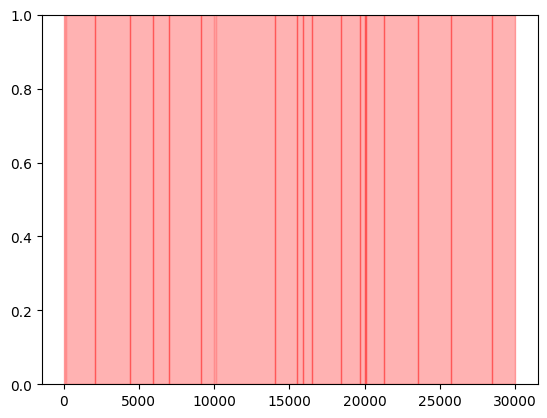

In [203]:
start_holding = None
end_holding = None
i = 1
for idx in sunlight.index:
    if massive_fluctuations_z[idx] == True:
        i+=1
        if not start_holding:
            start_holding = idx
    else:
        if start_holding:
            end_holding = idx
            # Plot the holding period in red overlay
            plt.axvspan(start_holding, end_holding, color='red', alpha=0.3)

            start_holding = None
            end_holding = None
plt.show()

In [204]:
sunlight['Pct_Change_EMA_30'] = sunlight['Pct_Change'].ewm(span=30,adjust=False).mean()
sunlight['Pct_Change_Threshold'] = sunlight['Pct_Change_EMA_30'].abs()* 2
#sunlight.drop('Sunlight_Threshold', axis=1, inplace=True)
print(sunlight.head())

   timestamp   SUNLIGHT  SMA_30  Pct_Change       EMA_30  STD_30  \
0          0  2500.0000     0.0    0.000000  2500.000000     0.0   
1        100  2499.4197     0.0   -0.023212  2499.962561     0.0   
2        200  2498.8457     0.0   -0.022965  2499.890506     0.0   
3        300  2498.2780     0.0   -0.022718  2499.786473     0.0   
4        400  2497.7166     0.0   -0.022471  2499.652933     0.0   

   Pct_Change_Stdev  STD_threshold  Sunlight_Z  Pct_Change_EMA_30  \
0               0.0            0.0         0.0           0.000000   
1               0.0            0.0         0.0          -0.001498   
2               0.0            0.0         0.0          -0.002883   
3               0.0            0.0         0.0          -0.004162   
4               0.0            0.0         0.0          -0.005344   

   Pct_Change_Threshold  
0              0.000000  
1              0.002995  
2              0.005765  
3              0.008325  
4              0.010687  


In [205]:
massive_per_flucuation = sunlight['Pct_Change'].abs() > sunlight['Pct_Change_Threshold']
print(massive_per_flucuation[massive_per_flucuation == True].shape)

# only 300 out of the 30,000, not a good predictor

(357,)


### Bollinger Bands

C:\Users\Acer\AppData\Local\Temp\ipykernel_9888\923138527.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sunlight_MA'] = df['SUNLIGHT'].ewm(window).mean()
C:\Users\Acer\AppData\Local\Temp\ipykernel_9888\923138527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sunlight_STD'] = df['SUNLIGHT'].rolling(window=window).std()
C:\Users\Acer\AppData\Local\Temp\ipykernel_9888\923138527.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

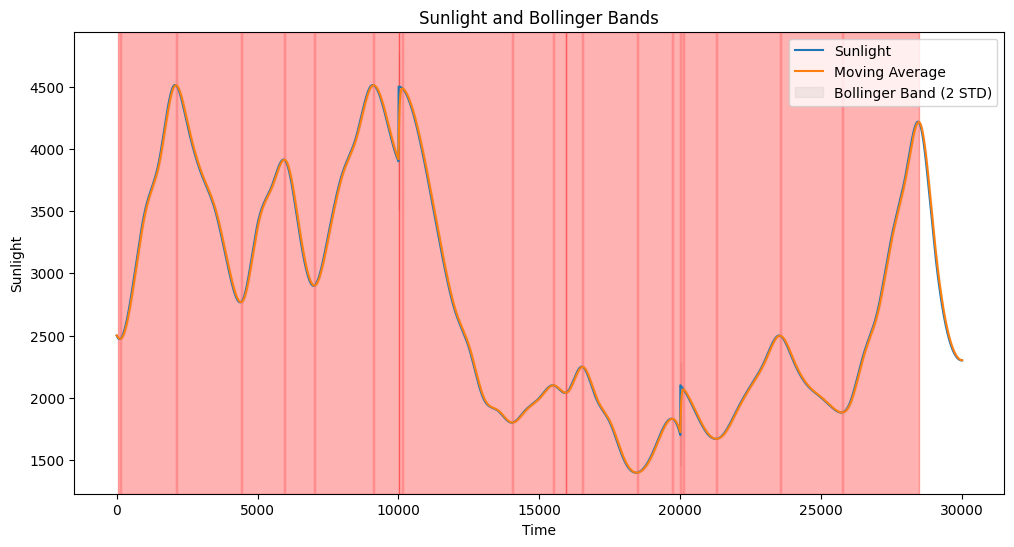

In [206]:
df = all_days.get(['timestamp','SUNLIGHT'])
# Assuming 'df' is your DataFrame with a 'Sunlight' column.

# Set the number of days for the moving average and standard deviation
window = 30

# Calculate the moving average (MA) of the sunlight
df['Sunlight_MA'] = df['SUNLIGHT'].ewm(window).mean()

# Calculate the rolling standard deviation
df['Sunlight_STD'] = df['SUNLIGHT'].rolling(window=window).std()

# Calculate the upper Bollinger Band
df['Upper_Band'] = df['Sunlight_MA'] + (df['Sunlight_STD'] * 2)

# Calculate the lower Bollinger Band
df['Lower_Band'] = df['Sunlight_MA'] - (df['Sunlight_STD'] * 2)

plt.figure(figsize=(12, 6))

# Plot the Sunlight
plt.plot(df.index, df['SUNLIGHT'], label='Sunlight')

# Plot the Moving Average
plt.plot(df.index, df['Sunlight_MA'], label='Moving Average')

# Plot the Bollinger Bands
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.1, label='Bollinger Band (2 STD)')


start_holding = None
end_holding = None
sunlight_bollinger = (df['SUNLIGHT'] < df['Lower_Band']) | (df['SUNLIGHT'] > df['Upper_Band'])
for idx in df.index:
    if sunlight_bollinger[idx] == True:
        if not start_holding:
            start_holding = idx
    else:
        if start_holding:
            end_holding = idx
            # Plot the holding period in red overlay
            plt.axvspan(start_holding, end_holding, color='red', alpha=0.3)

            start_holding = None
            end_holding = None

plt.title('Sunlight and Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Sunlight')
plt.legend(loc='best')
plt.show()


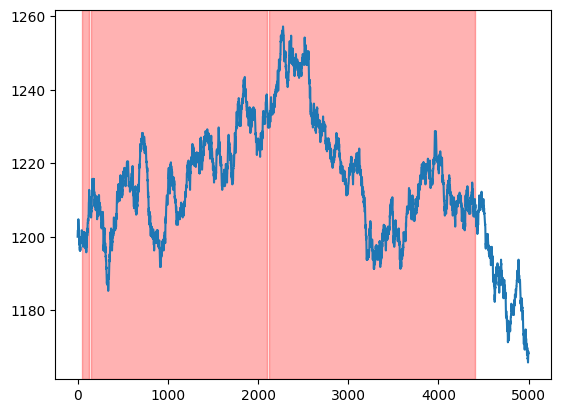

In [207]:
df = df[:5000]

# plot with orchid price
plt.plot(all_days['ORCHIDS'][:5000])
start_holding = None
end_holding = None
sunlight_bollinger = (df['SUNLIGHT'] < df['Lower_Band']) | (df['SUNLIGHT'] > df['Upper_Band'])
for idx in df.index:
    if sunlight_bollinger[idx] == True:
        if not start_holding:
            start_holding = idx
    else:
        if start_holding:
            end_holding = idx
            # Plot the holding period in red overlay
            plt.axvspan(start_holding, end_holding, color='red', alpha=0.3)

            start_holding = None
            end_holding = None

plt.show()